## DataLoaders requirements

I'd like to share with you how you can work with (very large) numpy arrays in **fastai2** through a time series classification example.

**High level requirements:**

* Use univariate and multivariate time series
* Use labeled (X,y) and unlabeled (X,) datasets
* Data may be already split in train/ valid
* In-memory and on-disk np.arrays (np.memmap in case of larger than RAM data)
* Slice the dataset (based on selected variables and/ or sequence steps)
* Use item and batch tfms
* Create batch with specified output types (TSTensor, TensorCategory, etc)
* Show batch (with tfms)
* Show results
* Add test data and unlabeled datasets
* Export and predict on new data
* Better performance than native Pytorch, fastai v1 & vanilla fastai v2

These are pretty challanging requirements. Let's see if fastai2 can meet them with little configuration.

## Import libraries

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-2zspuuzp
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-2zspuuzp
  Created wheel for fastai2: filename=fastai2-0.0.17-cp36-none-any.whl size=187332 sha256=a3ae5952b6f030c5a8e4bf471a97632f33834b0130c4cc73f4a57a0dc6aec6e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ya2ekoqa/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-9bc5ictr
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-9bc5ictr
  Created wheel for fastcore: filename=fastcore-0.1.17-cp36-none-any.whl size=28221 sha256=aa79fa8441a3ca56843c28f65cf9310d41475336c55e0204529f8bcaf7ddf1a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-qj_9ps82/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Found existing installation: fastcore 0.1.

In [ ]:
# Uncomment if needed to reload repo
# %cd ..
# !rm -rf timeseriesAI2
# !git clone https://github.com/timeseriesAI/timeseriesAI2.git
# %cd timeseriesAI2

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [1]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.vision.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [2]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *
print(fastai2.__version__)
print(fastcore.__version__)

0.0.16
0.1.17


In [11]:
import fastai2, fastcore
from fastai2.imports import *
from fastai2.data.all import *
import numpy as np
print(fastai2.__version__)
print(fastcore.__version__)

0.0.16
0.1.17


In [15]:
X = np.random.rand(5, 1, 2)
y = np.random.randint(1, 3, 5)
items = L(X,y).zip()
TfmdLists(items, ItemGetter(1))[0]

1

## Load data

In [10]:
# dataset id
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_in_memory = np.concatenate((X_train, X_valid))
y_in_memory = np.concatenate((y_train, y_valid)).astype(int)
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X_in_memory)
np.save(f'{folder}/{dsid}/y.npy', y_in_memory)
X_on_disk = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y_on_disk = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r').astype(int)
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X_on_disk)))))

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



## Performance benchmark

### Pytorch dataloader

In [0]:
# Native Pytorch
class PytorchDataset():
    def __init__(self, X, y=None): self.X, self.y = torch.as_tensor(X), torch.as_tensor(y)
    def __getitem__(self, idx): return (self.X[idx], self.y[idx])
    def __len__(self): return len(self.X)

In [7]:
ds    = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dl    = torch.utils.data.DataLoader(ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(len(ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dl)

shape: 8236         bs: torch.Size([128, 1, 1024])
10 loops, best of 3: 47 ms per loop


### Fastai v1

For reference, this are the timings achieved with fastai v1 under the same conditions: 

- cycle_dl:  1.01s
- total training time: 102 s

### Fastai v2

In [11]:
X = np.random.rand(5, 1, 2)
y = np.random.randint(1, 3, 5)
items = L(X,y).zip()
TfmdLists(items, [ItemGetter(1)])[0]

1

In [3]:
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TransformBlock, CategoryBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
# %timeit cycle_dl(dls.valid)

NameError: name 'splits' is not defined

In [ ]:
X = np.random.rand(5, 1, 2)
y = np.random.randint(1, 3, 5)
items = L(X,y).zip()
TfmdLists(items, [ItemGetter(1)], Categorize())[0]

In [0]:
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 3.43 s per loop


Sylvain Gugger provided an alternative recommendation in this [post](https://forums.fast.ai/t/datablock-with-numpy-input/64848/2):

"You can create a DataLoaders object from regular PyTorch datasets (though all the visualization methods like show_batch and show_results will fail)."

In [0]:
train_ds = PytorchDataset(np.array(X_train), np.array(y_train).astype(int))
valid_ds = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 892 ms per loop


## NumpyDatasets & NumpyDataLoader

In [0]:
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = None, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 preprocess=False, **kwargs):

        if tls is None: items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = slice(None) if sel_vars is None else sel_vars
        self.sel_steps = slice(None) if sel_steps is None else sel_steps
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        self.ptls = L([tl.items if is_none(tfm) else np.stack(tl[:]) if preprocess else tl for tl,tfm in zip(self.tls, self.tfms)])
        self.preprocess = preprocess
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it][self.sel_vars, self.sel_steps] if i==0 else ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           preprocess=self.preprocess, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = ifnone(items,ifnoneelse(y,tuple((X,)),tuple((X, y))))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    @property
    def vars(self): return self[0][0].shape[-2]

    @property
    def length(self): return self[0][0].shape[-1]

    @property
    def types(self):
        if self.tls: 
            types = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else torch.as_tensor for tl in self.tls]
            if self._xtype is not None: types[0] = self._xtype
            if len(types) == 2 and self._ytype is not None: types[1] = self._ytype
            return types 


class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    

class NumpyDataLoader(TfmdDL):
    do_item = noops
    
    def create_batch(self, b): return self.dataset[b]
    
    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def length(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(db), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs):
            show_tuple(db[i], ctx=ctx)

    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): 
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)


@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], **kwargs)
    
class TSDataLoader(NumpyDataLoader): pass

In [0]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

(TSTensor(vars:1, len:1024), TensorCategory(1))


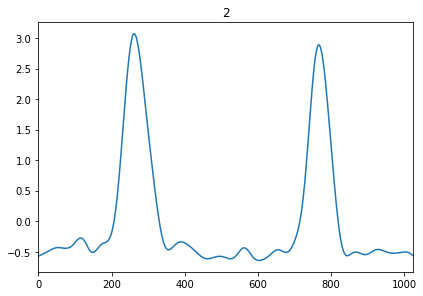

In [144]:
tfms = [None, [Categorize()]]
# tfms = None
# dsets = NumpyDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
test_ds  = dsets.add_ds(X_in_memory, y_in_memory)
print(valid_ds[0])
show_at(valid_ds, 0);

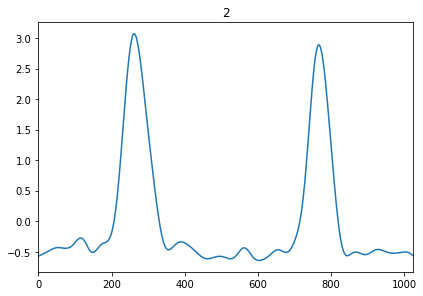

In [133]:
valid_ds.show(valid_ds[0]);

In [124]:
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls = TSDataLoaders(train_dl, valid_dl)
b = next(iter(dls.valid))
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
         1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
         2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
         1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
         2, 2, 2, 2, 1, 2, 2, 0]))

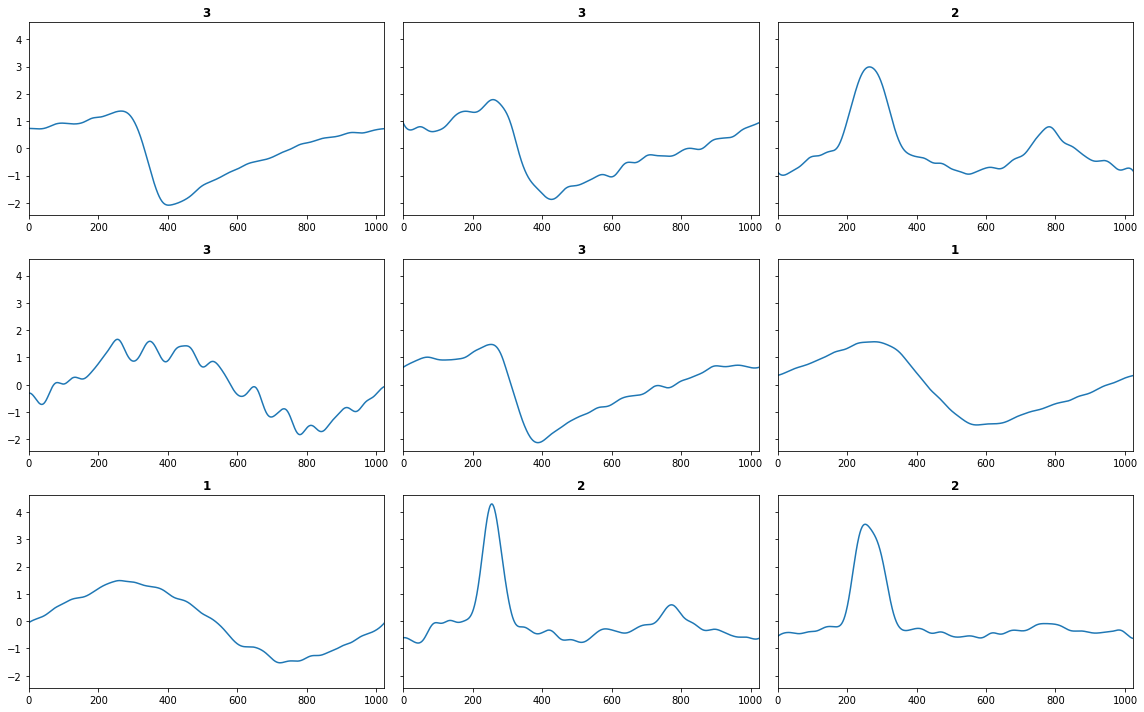

In [125]:
dls.train.show_batch(sharey=True)

In [19]:
X_val = X_in_memory[splits[1]]
y_val = y_in_memory[splits[1]]
tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3,
         3, 2, 3, 1, 3, 2, 3, 1, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         2, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 2, 3, 3, 3, 3, 2,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 1, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3,
         3, 3, 2, 1, 2, 3, 3, 3, 2, 1, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2,
         3, 2, 2, 3, 3, 3, 2, 2]))

In [24]:
%timeit tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

The slowest run took 4.59 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 157 µs per loop


In [18]:
valid_ds[valid_idx]

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
         2, 1, 2, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2,
         2, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1,
         2, 1, 1, 2, 2, 2, 1, 1]))

In [0]:
# Preprocess = False
%timeit valid_ds[valid_idx]

100 loops, best of 3: 14.5 ms per loop


In [0]:
%timeit cycle_dl(valid_dl)

1 loop, best of 3: 929 ms per loop


In [17]:
# Preprocess = False
%timeit valid_ds[valid_idx]

10000 loops, best of 3: 161 µs per loop


In [23]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 30.8 ms per loop


In [0]:
# Preprocess = False, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=False)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn2 = Learner(dls, model, metrics=accuracy)
start = time.time()
learn2.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.705418,1.009921,0.676663,00:03
1,0.570929,0.650547,0.831836,00:03
2,0.493112,0.624059,0.746479,00:03
3,0.418206,0.274643,0.894609,00:03
4,0.362605,0.542397,0.773434,00:03
5,0.307633,0.274911,0.875304,00:03
6,0.261671,1.009938,0.856484,00:03
7,0.236244,0.156257,0.944998,00:03
8,0.202548,0.127820,0.968310,00:03
9,0.176167,0.111701,0.974259,00:03


97.16755080223083


In [0]:
# Preprocess = False, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.730351,1.026829,0.798567,00:02
1,0.582621,0.644263,0.845920,00:02
2,0.486823,0.408003,0.852477,00:02
3,0.414061,0.607993,0.692448,00:02
4,0.347909,0.663359,0.855755,00:02
5,0.298066,0.179185,0.951797,00:02
6,0.251365,0.192588,0.930306,00:02
7,0.211995,0.255828,0.932127,00:02
8,0.180487,0.470174,0.857334,00:02
9,0.154197,0.240356,0.905901,00:02


73.67140460014343


In [0]:
# Preprocess = False, Data on disk
tfms = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True)
valid_dl = TSDataLoader(valid_ds, bs=128)
dls = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.799278,1.068762,0.577222,00:03
1,0.647836,0.694410,0.835600,00:03
2,0.546813,0.423343,0.851627,00:03
3,0.451487,0.337685,0.856484,00:03
4,0.392121,0.434699,0.834628,00:03
5,0.338288,0.906969,0.849077,00:03
6,0.302274,0.739665,0.855027,00:03
7,0.265216,0.229490,0.928485,00:03
8,0.227199,0.891239,0.787882,00:03
9,0.200662,0.167834,0.956897,00:03


82.7504723072052


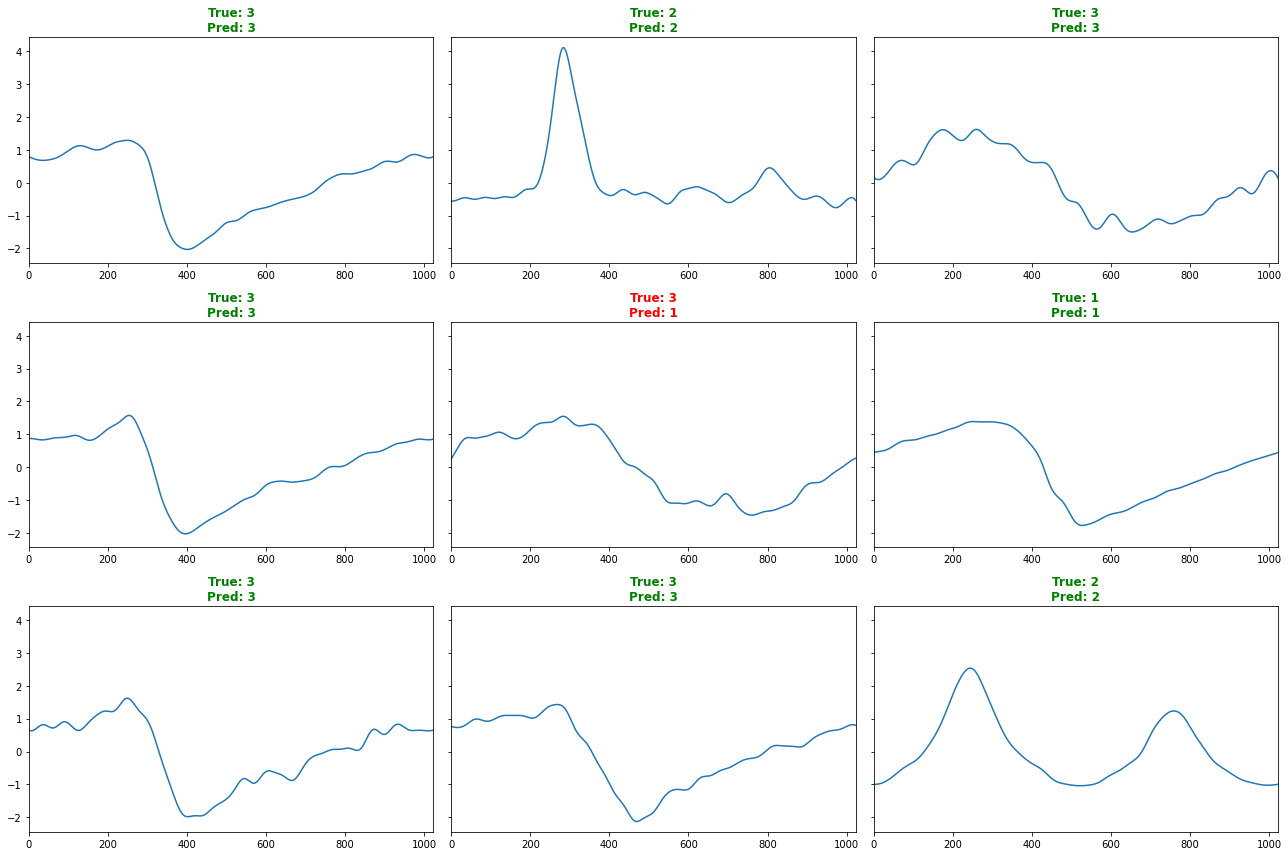

In [26]:
learn.show_results(sharey=True)

In [237]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(3, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.608039,0.875217,0.767120,00:02
1,0.438873,0.729845,0.558038,00:02
2,0.347714,0.340342,0.847256,00:02


8.937021017074585


In [0]:
# Save the dataset
dsets_fname = 'dsets'
torch.save(dsets, dsets_fname)

# Saves the model along with optimizer
save_fname = 'learner'
learn.save(save_fname)

# Export learn without the items (data) and the optimizer state for inference
export_fname = 'export.pkl'
learn.export(export_fname)

In [0]:
try: del dsets
except: pass
try: del learn
except: pass

In [0]:
# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)
learn.dls[0].dataset = dsets.train
learn.dls[1].dataset = dsets.valid

In [241]:
train_probas, train_targets, train_preds = learn.get_preds(ds_idx=0, with_decoded=True, save_preds=None, save_targs=None)
valid_probas, valid_targets, valid_preds = learn.get_preds(ds_idx=1, with_decoded=True, save_preds=None, save_targs=None)
valid_probas, valid_targets, valid_preds

(tensor([[0.0233, 0.9468, 0.0299],
         [0.1551, 0.0867, 0.7582],
         [0.1619, 0.0739, 0.7642],
         ...,
         [0.2072, 0.0259, 0.7669],
         [0.0265, 0.9401, 0.0334],
         [0.0343, 0.0141, 0.9516]]),
 tensor([1, 2, 2,  ..., 0, 1, 2]),
 tensor([1, 2, 2,  ..., 2, 1, 2]))

In [242]:
(valid_targets == valid_preds).float().mean()

tensor(0.8473)

In [0]:
def add_ds(dsets, X, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create test datasets from X (and y) using validation transforms of `dsets`"
    items = tuple((X,)) if y is None else tuple((X, y))
    with_labels = False if y is None else True
    if isinstance(dsets, (Datasets, NumpyDatasets, TSDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(item)) for tl,item in zip(new_tls, items)]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, (NumpyDatasets, TSDatasets)):
            cls = dsets.__class__
            return cls(tls=new_tls, n_inp=dsets.n_inp, preprocess=dsets.preprocess, tfms=dsets.tfms, sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps)
        elif isinstance(dsets, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

def add_test(dsets, X, y=None, test_items=None, rm_tfms=None, with_labels=False):
    return add_ds(dsets, X, y=y, test_items=test_items, rm_tfms=rm_tfms, with_labels=with_labels)

NumpyDatasets.add_test = add_test
# TSDatasets.add_test = add_test

def add_unlabeled(dsets, X, test_items=None, rm_tfms=None, with_labels=False):
    return add_ds(dsets, X, y=None, test_items=test_items, rm_tfms=rm_tfms, with_labels=with_labels)

NumpyDatasets.add_unlabeled = add_unlabeled
# TSDatasets.add_unlabeled = add_unlabeled

In [271]:
# Labeled test data
# Let's first delete the datasets and learner
try: del dsets
except: pass
try: del learn
except: pass
# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)

# And now we load a new dataset
test_ds = dsets.add_test(X_in_memory, y_in_memory)
test_dl = learn.dls[1].new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
         1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
         2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 1, 2, 0, 2], device='cuda:0'))

In [272]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[0.0707, 0.0150, 0.9143],
         [0.2448, 0.0234, 0.7318],
         [0.2458, 0.0253, 0.7289],
         ...,
         [0.2072, 0.0259, 0.7669],
         [0.0265, 0.9401, 0.0334],
         [0.0343, 0.0141, 0.9516]]),
 tensor([2, 2, 0,  ..., 0, 1, 2]),
 tensor([2, 2, 2,  ..., 2, 1, 2]))

In [273]:
# Unlabeled test data
# Let's first delete the datasets and learner
try: del dsets
except: pass
try: del learn
except: pass
# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)

# And now we load a new dataset
test_ds = dsets.add_test(X_in_memory)
test_dl = learn.dls[1].new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:1, len:1024),)

In [274]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

tensor([[0.0707, 0.0150, 0.9143],
        [0.2448, 0.0234, 0.7318],
        [0.2458, 0.0253, 0.7289],
        ...,
        [0.2072, 0.0259, 0.7669],
        [0.0265, 0.9401, 0.0334],
        [0.0343, 0.0141, 0.9516]])

In [275]:
# Unlabeled dataset
# Let's first delete the datasets and learner
try: del dsets
except: pass
try: del learn
except: pass
# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)

# And now we load a new datasets
unlabeled_ds = dsets.add_unlabeled(X_in_memory)
unlabeled_dl = learn.dls[1].new(unlabeled_ds)
b = next(iter(unlabeled_dl))
b

(TSTensor(samples:128, vars:1, len:1024),)

In [276]:
u_probas, *_ = learn.get_preds(dl=unlabeled_dl, save_preds=None)
u_probas

tensor([[0.0707, 0.0150, 0.9143],
        [0.2448, 0.0234, 0.7318],
        [0.2458, 0.0253, 0.7289],
        ...,
        [0.2072, 0.0259, 0.7669],
        [0.0265, 0.9401, 0.0334],
        [0.0343, 0.0141, 0.9516]])